In [51]:
import numpy as np
import pandas as pd

In [52]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [53]:
import pandas as pd
import pandas_profiling 

import seaborn as sns
import matplotlib.style as style
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import boxcox_normmax
from scipy.special import boxcox1p
from scipy.stats import norm, skew
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor

import warnings
warnings.filterwarnings('ignore')

In [54]:
house_train= pd.read_csv('~/Downloads/house-prices-advanced-regression-techniques/train.csv')
house_test= pd.read_csv('~/Downloads/house-prices-advanced-regression-techniques/test.csv')
print("Dataset shape:",'house_train', house_train.shape, 'house_test', house_test.shape)

Dataset shape: house_train (1460, 81) house_test (1459, 80)


<AxesSubplot:>

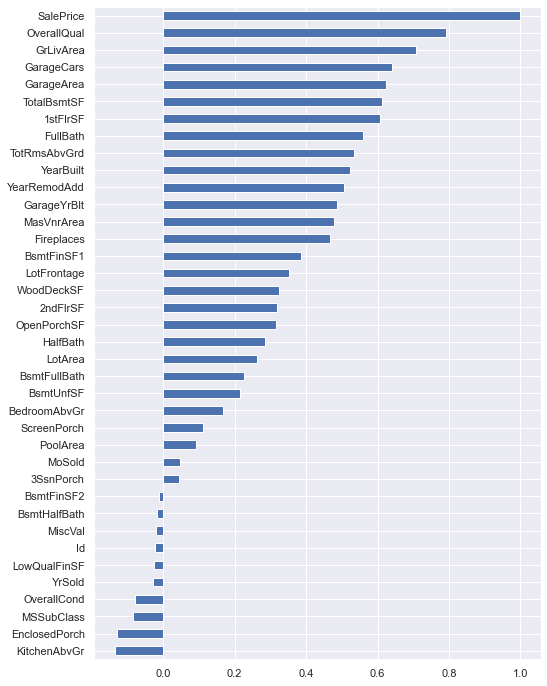

In [55]:
plt.figure(figsize=(8, 12))
house_train.corr()['SalePrice'].sort_values().plot(kind='barh')

<AxesSubplot:>

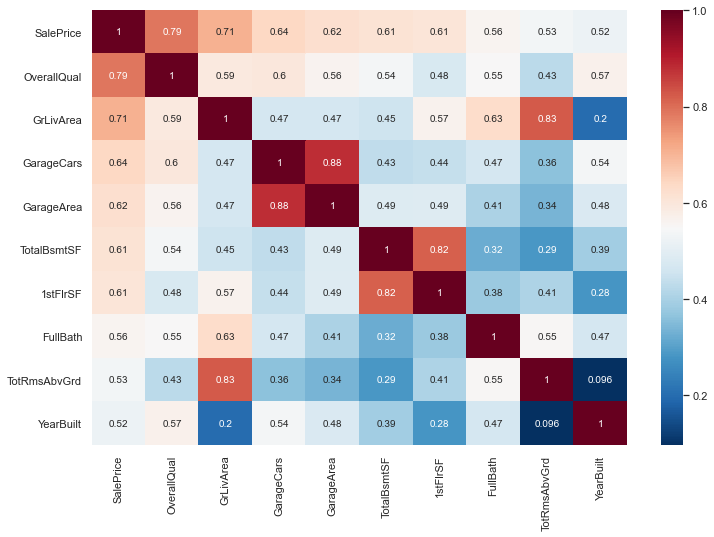

In [56]:
k = 10
cols = house_train.corr().nlargest(k, 'SalePrice')['SalePrice'].index
k_corr_matrix = house_train[cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(k_corr_matrix, annot=True, cmap=plt.cm.RdBu_r)

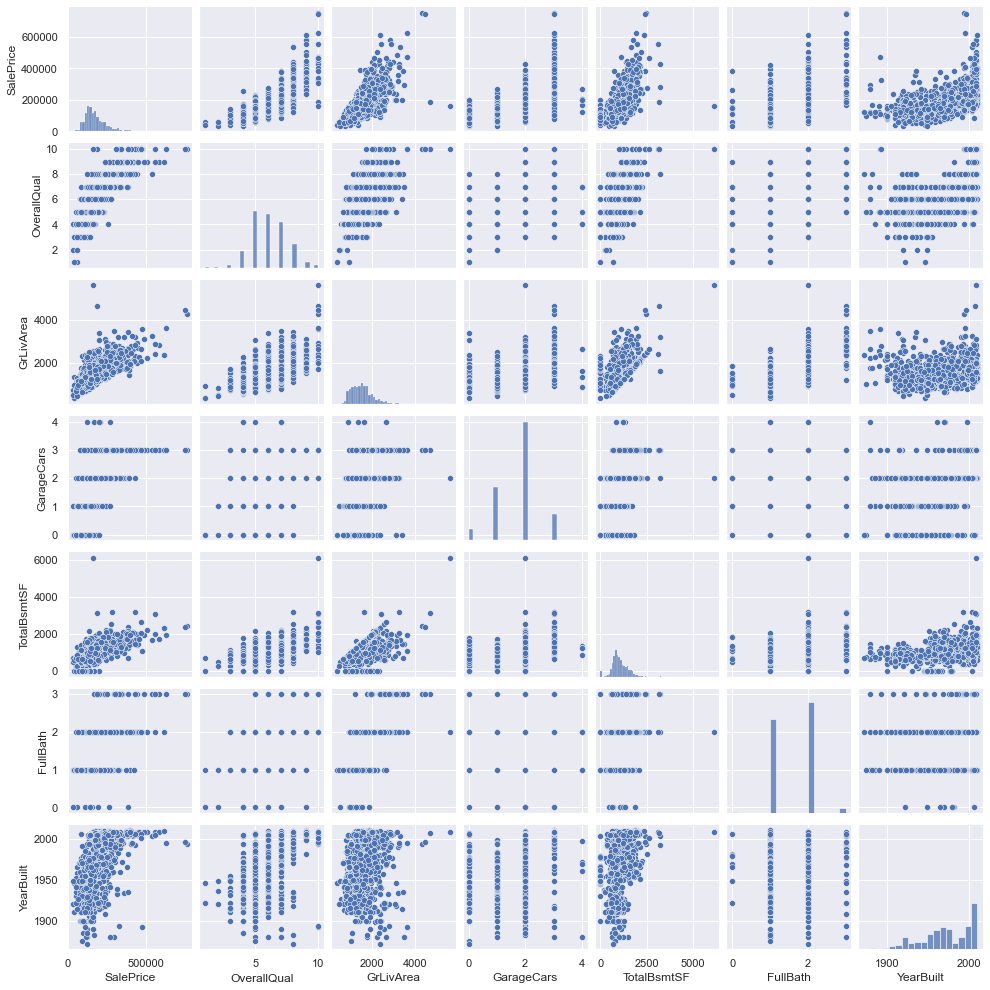

In [57]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(house_train[cols], size = 2)
plt.show()

<AxesSubplot:xlabel='SalePrice'>

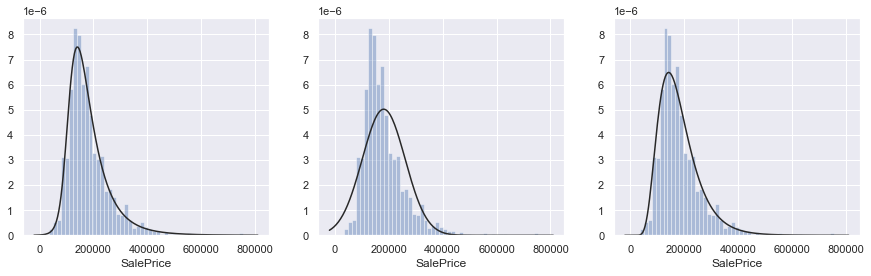

In [58]:
target = house_train['SalePrice']
f, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.distplot(target, kde=False, fit=stats.johnsonsu, ax=axes[0])
sns.distplot(target, kde=False, fit=stats.norm, ax=axes[1])
sns.distplot(target, kde=False, fit=stats.lognorm, ax=axes[ 2])

In [59]:
house_train['SalePrice'] = np.log1p(house_train['SalePrice'])

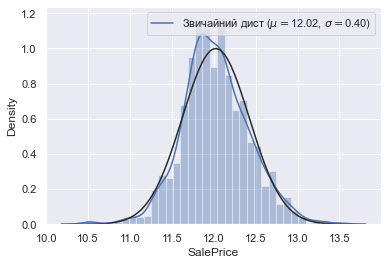

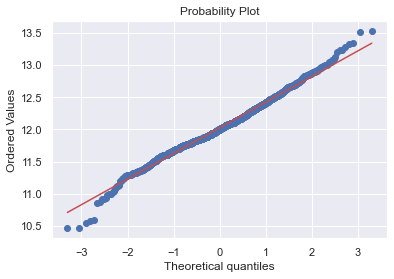

In [60]:
(mu, sigma) = norm.fit(house_train['SalePrice'])
sns.distplot(house_train['SalePrice'], fit=norm)
plt.legend(['Звичайний дист ($\mu=${:.2f}, $\sigma=${:.2f})'.format(mu, sigma)])

fig = plt.figure()
stats.probplot(house_train['SalePrice'], plot=plt)
plt.show()

In [61]:
def detect_outliers(x, y, top=5, plot=True):
    lof = LocalOutlierFactor(n_neighbors=40, contamination=0.1)
    x_ =np.array(x).reshape(-1,1)
    preds = lof.fit_predict(x_)
    lof_scr = lof.negative_outlier_factor_
    out_idx = pd.Series(lof_scr).sort_values()[:top].index
    if plot:
        f, ax = plt.subplots(figsize=(9, 6))
        plt.scatter(x=x, y=y, c=np.exp(lof_scr), cmap='RdBu')
    return out_idx

Int64Index([1298, 523, 1182, 691, 533], dtype='int64')

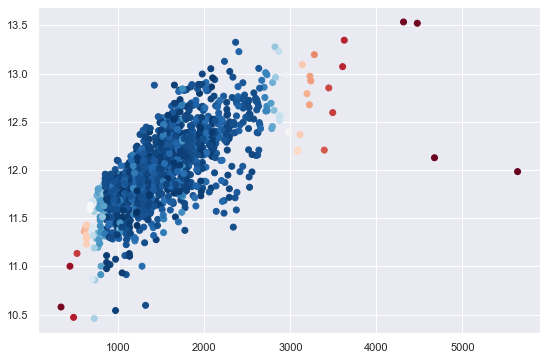

In [62]:
outs = detect_outliers(house_train['GrLivArea'], house_train['SalePrice'],top=5) 
outs

In [63]:
quantitative = [feature for feature in house_train.columns if house_train.dtypes[feature] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [feature for feature in house_train.columns if house_train.dtypes[feature] == 'object']

In [64]:
from collections import Counter
all_outliers=[]

for feature in quantitative:
    try:
        outs = detect_outliers(house_train[feature], house_train['SalePrice'],top=5, plot=False)
    except:
        continue
    all_outliers.extend(outs)

print(Counter(all_outliers).most_common())

outliers = [30, 88, 462, 523, 632, 1298, 1324] #
for i in outliers:
    if i in all_outliers:
        print(i)

[(1298, 4), (1270, 3), (375, 3), (533, 3), (523, 3), (635, 3), (634, 3), (0, 3), (976, 3), (975, 3), (978, 3), (977, 3), (313, 2), (335, 2), (1213, 2), (812, 2), (77, 2), (7, 2), (953, 2), (496, 2), (1182, 2), (954, 2), (597, 2), (1163, 2), (1350, 2), (1328, 2), (164, 1), (873, 1), (589, 1), (555, 1), (249, 1), (706, 1), (451, 1), (636, 1), (916, 1), (1100, 1), (304, 1), (508, 1), (218, 1), (1442, 1), (1058, 1), (240, 1), (1166, 1), (591, 1), (277, 1), (771, 1), (1140, 1), (1223, 1), (699, 1), (219, 1), (229, 1), (790, 1), (930, 1), (1028, 1), (695, 1), (645, 1), (1149, 1), (125, 1), (599, 1), (574, 1), (332, 1), (440, 1), (1024, 1), (1373, 1), (431, 1), (1400, 1), (185, 1), (170, 1), (1009, 1), (88, 1), (691, 1), (738, 1), (188, 1), (326, 1), (624, 1), (298, 1), (1283, 1), (53, 1), (189, 1), (809, 1), (48, 1), (203, 1), (434, 1), (1218, 1), (642, 1), (166, 1), (309, 1), (605, 1), (1190, 1), (747, 1), (420, 1), (1340, 1), (542, 1), (1372, 1), (516, 1), (351, 1), (1060, 1), (499, 1), (6

In [65]:
house_train = house_train.drop(house_train.index[outliers])
house_train.shape

(1453, 81)

In [66]:
house_train.reset_index(drop=True, inplace=True)
y_train = house_train['SalePrice']
X_train = house_train.drop(['SalePrice'], axis=1)
X_test = house_test

print("Форма набору даних:",'X_train', X_train.shape, 'y_train', y_train.shape, 'X_test', X_test.shape)

Форма набору даних: X_train (1453, 80) y_train (1453,) X_test (1459, 80)


In [67]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics_train = []; numerics_test = []
for i in house_train.columns: 
    if house_train[i].dtype in numeric_dtypes:
        numerics_train.append(i)
house_train.update(house_train[numerics_train].fillna(0))
for i in house_test.columns:
    if house_test[i].dtype in numeric_dtypes:
        numerics_test.append(i)
house_test.update(house_test[numerics_test].fillna(0))

In [68]:
skew_train = house_train[quantitative].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew_train = skew_train[skew_train > 0.5] #skewness value
for i in high_skew_train.index:
    house_train[i] = boxcox1p(house_train[i], boxcox_normmax(house_train[i] + 1))

skew_test = house_test[quantitative].apply(lambda x: skew(x)).sort_values(ascending=False)    
high_skew_test = skew_test[skew_train > 0.5]
for i in high_skew_test.index:
    house_test[i] = boxcox1p(house_test[i], boxcox_normmax(house_test[i] + 1))

зовнішній діапазон (низький) розподілу: 
[[-3.94740172]
 [-3.91789931]
 [-3.73959854]
 [-3.64819241]
 [-2.94256343]]
зовнішній діапазон (високий) розподілу: 
[[3.14776804]
 [3.26897771]
 [3.32335889]
 [3.76594996]
 [3.79955024]]


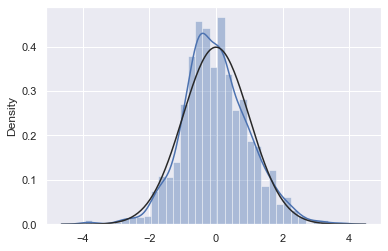

In [69]:
sale_price_scaled = StandardScaler().fit_transform(house_train['SalePrice'][:, np.newaxis])

sns.distplot(sale_price_scaled, fit=norm)

low_range = sale_price_scaled[sale_price_scaled[:, 0].argsort()[:5]]
high_range = sale_price_scaled[sale_price_scaled[:, 0].argsort()[-5:]]
print(f'зовнішній діапазон (низький) розподілу: \n{low_range}')
print(f'зовнішній діапазон (високий) розподілу: \n{high_range}')

In [70]:
all_data = pd.concat([X_train, house_test], axis=0, sort=False)
all_data.drop(['Id'], axis=1, inplace=True)
all_data.shape

(2912, 79)

In [71]:
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [72]:
na_total = all_data.isnull().sum().sort_values(ascending=False)
na_ratio = (all_data.isnull().sum() / all_data.shape[0]).sort_values(ascending=False)
missing_data = pd.concat([na_total, na_ratio], axis=1, keys=['Total', 'Ratio'])
missing_data.head(10)

,Total,Ratio
PoolQC,2903,0.996909
MiscFeature,2807,0.963942
Alley,2715,0.932349
Fence,2344,0.804945
FireplaceQu,1418,0.486951
LotFrontage,259,0.088942
GarageQual,158,0.054258
GarageCond,158,0.054258
GarageFinish,158,0.054258
GarageType,156,0.053571


In [73]:
all_data.drop(['PoolQC', 'Utilities', 'Street', 'MiscFeature', ], axis=1, inplace=True)

In [74]:
for col in ('Alley','Fence','FireplaceQu','GarageQual','GarageFinish','GarageCond','GarageType','BsmtExposure',
          'BsmtCond','BsmtQual','BsmtFinType2','BsmtFinType1'):
     all_data[col] = all_data[col].fillna(0)

In [75]:
print(all_data[all_data['GarageCars'].isnull()][['GarageArea', 'GarageCars', 'GarageType', 'GarageYrBlt', 'GarageQual']])
all_data['GarageArea'].fillna(0, inplace=True)
all_data['GarageCars'].fillna(0, inplace=True)

Empty DataFrame
Columns: [GarageArea, GarageCars, GarageType, GarageYrBlt, GarageQual]
Index: []


In [76]:
print(all_data[all_data['TotalBsmtSF'].isnull()][
    ['TotalBsmtSF', 'BsmtFinSF2', 'BsmtUnfSF', 'BsmtFinSF1', 'BsmtFullBath','BsmtHalfBath']])
for col in ('TotalBsmtSF', 'BsmtFinSF2', 'BsmtUnfSF', 'BsmtFinSF1', 'BsmtFullBath','BsmtHalfBath'):
     all_data[col] = all_data[col].fillna(0)

Empty DataFrame
Columns: [TotalBsmtSF, BsmtFinSF2, BsmtUnfSF, BsmtFinSF1, BsmtFullBath, BsmtHalfBath]
Index: []


In [77]:
all_data['MasVnrType'].fillna('None', inplace=True)
all_data['HasMasVnr'] = all_data['MasVnrType'].apply(lambda x: 0 if x == 'None' else 1)

In [78]:
X_train = all_data.iloc[:len(y_train), :]
X_test = all_data.iloc[len(y_train):, :]
print("Dataset shape:",'X_train', X_train.shape, 'y_train', y_train.shape, 'X_test', X_test.shape)

Dataset shape: X_train (1453, 76) y_train (1453,) X_test (1459, 76)


In [79]:
X_train['MSZoning'] = X_train.groupby(['MSSubClass'])['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
X_test['MSZoning'] = X_test.groupby(['MSSubClass'])['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

for col in ('Functional','Exterior1st','Electrical','KitchenQual','SaleType','Exterior2nd'):
    X_train[col] = X_train[col].fillna(X_train[col].mode()[0])
    X_test[col] = X_test[col].fillna(X_test[col].mode()[0])

In [80]:
X_train['LotFrontage'] = X_train.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
X_train['GarageYrBlt'] = (X_train['YearBuilt'] + X_train['YearRemodAdd']) /2
X_train['MasVnrArea'] = X_train.groupby(['MasVnrType'])['MasVnrArea'].transform(lambda x: x.fillna(x.median()))

X_test['LotFrontage'] = X_test.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
X_test['GarageYrBlt'] = (X_test['YearBuilt'] + X_test['YearRemodAdd']) /2
X_test['MasVnrArea'] = X_test.groupby(['MasVnrType'])['MasVnrArea'].transform(lambda x: x.fillna(x.median()))

In [81]:
X_train['YrBltAndRemod']=X_train['YearBuilt']+X_train['YearRemodAdd']
X_train['TotalSF']=X_train['TotalBsmtSF'] + X_train['1stFlrSF'] + X_train['2ndFlrSF']
X_train['TotalSqrFootage'] = (X_train['BsmtFinSF1'] + X_train['BsmtFinSF2'] +
                                 X_train['1stFlrSF'] + X_train['2ndFlrSF'])
X_train['TotalBathrooms'] = (X_train['FullBath'] + (0.5 * X_train['HalfBath']) +
                               X_train['BsmtFullBath'] + (0.5 * X_train['BsmtHalfBath']))
X_train['TotalPorchSF'] = (X_train['OpenPorchSF'] + X_train['3SsnPorch'] +
                              X_train['EnclosedPorch'] + X_train['ScreenPorch'] +
                              X_train['WoodDeckSF'])

X_test['YrBltAndRemod']=X_test['YearBuilt']+X_test['YearRemodAdd']
X_test['TotalSF']=X_test['TotalBsmtSF'] + X_test['1stFlrSF'] + X_test['2ndFlrSF']
X_test['TotalSqrFootage'] = (X_test['BsmtFinSF1'] + X_test['BsmtFinSF2'] +
                                 X_test['1stFlrSF'] + X_test['2ndFlrSF'])
X_test['TotalBathrooms'] = (X_test['FullBath'] + (0.5 * X_test['HalfBath']) +
                               X_test['BsmtFullBath'] + (0.5 * X_test['BsmtHalfBath']))
X_test['TotalPorchSF'] = (X_test['OpenPorchSF'] + X_test['3SsnPorch'] +
                              X_test['EnclosedPorch'] + X_test['ScreenPorch'] +
                              X_test['WoodDeckSF'])

In [82]:
X_train['has2ndfloor'] = X_train['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
X_train['hasgarage'] = X_train['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
X_train['hasbsmt'] = X_train['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
X_train['hasfireplace'] = X_train['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

X_test['has2ndfloor'] = X_test['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
X_test['hasgarage'] = X_test['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
X_test['hasbsmt'] = X_test['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
X_test['hasfireplace'] = X_test['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [83]:
print("Dataset shape:",'X_train', X_train.shape, 'y_train', y_train.shape, 'X_test', X_test.shape)

Dataset shape: X_train (1453, 85) y_train (1453,) X_test (1459, 85)


In [84]:
import category_encoders as ce
ohe = ce.OneHotEncoder(handle_unknown='ignore', use_cat_names=True)
encoded_data=ohe.fit_transform(pd.concat([X_train,X_test], axis=0, sort=False)).reset_index(drop=True)
X_train =  encoded_data.iloc[:len(y_train), :]
X_test = encoded_data.iloc[len(y_train):, :]
print("Dataset shape:",'X_train', X_train.shape, 'y_train', y_train.shape, 'X_test', X_test.shape)

Dataset shape: X_train (1453, 343) y_train (1453,) X_test (1459, 343)


In [85]:
X_test.isnull().sum().sort_values(ascending=False)

MSSubClass_60.0      0
Electrical_SBrkr     0
GrLivArea            0
LowQualFinSF         0
2ndFlrSF             0
                    ..
OverallCond          0
OverallQual          0
HouseStyle_2.5Fin    0
HouseStyle_2.5Unf    0
hasfireplace         0
Length: 343, dtype: int64

In [86]:
overfit = []
len_X_train =len(X_train)

for i in X_train.columns:
    counts = X_train[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len_X_train * 100 > 99.94 :
        overfit.append(i)

overfit = list(overfit)
overfit.append('MSZoning_C (all)')

X_train = np.array(X_train.drop(overfit, axis=1).copy())
y_train = np.array(y_train)
X_test = np.array(X_test.drop(overfit, axis=1).copy())

print("Dataset shape:",'X_train', X_train.shape, 'y_train', y_train.shape, 'X_test', X_test.shape)

Dataset shape: X_train (1453, 326) y_train (1453,) X_test (1459, 326)


In [87]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import ElasticNet, Lasso, Ridge, ElasticNetCV, LassoCV, RidgeCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from mlxtend.regressor import StackingCVRegressor

In [88]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def rmsle(y, y_pred):
    return np.sqrt(mse(y, y_pred))

def cv_rmse(model, X_train=X_train):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [89]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [90]:
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))

lasso = make_pipeline(
    RobustScaler(),
    LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kfolds))

elasticnet = make_pipeline(
    RobustScaler(),
    ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))

svr = make_pipeline(RobustScaler(), SVR(
    C=20,
    epsilon=0.009,
    gamma=0.0003,
))

gbr = GradientBoostingRegressor(n_estimators=3000,
                                learning_rate=0.05,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)

lightgbm = LGBMRegressor(
    objective='regression',
    num_leaves=4,
    learning_rate=0.01,
    n_estimators=5000,
    max_bin=200,
    bagging_fraction=0.75,
    bagging_freq=5,
    bagging_seed=7,
    feature_fraction=0.2,
    feature_fraction_seed=7,
    verbose=-1,
)

xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=3460,
                       max_depth=5,
                       min_child_weight=0,
                       gamma=0,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:squarederror',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006)

In [91]:
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [92]:
print('ТЕСТ бал на CV')

score = cv_rmse(ridge) 
print("Ridge оцінка: {:.4f} ({:.4f})".format(score.mean(), score.std()))

score = cv_rmse(lasso)
print("Lasso оцінка: {:.4f} ({:.4f})".format(score.mean(), score.std()))

score = cv_rmse(elasticnet)
print("ElasticNet оцінка: {:.4f} ({:.4f})".format(score.mean(), score.std()))

score = cv_rmse(svr)
print("SVR оцінка: {:.4f} ({:.4f})".format(score.mean(), score.std()))

score = cv_rmse(lightgbm)
print("Lightgbm оцінка: {:.4f} ({:.4f})".format(score.mean(), score.std()))

score = cv_rmse(gbr)
print("GradientBoosting оцінка: {:.4f} ({:.4f})".format(score.mean(), score.std()))

score = cv_rmse(xgboost)
print("Xgboost оцінка: {:.4f} ({:.4f})".format(score.mean(), score.std()))

ТЕСТ бал на CV
Ridge оцінка: 0.1058 (0.0145)
Lasso оцінка: 0.1063 (0.0154)
ElasticNet оцінка: 0.1063 (0.0154)
SVR оцінка: 0.1724 (0.0236)
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, co

In [93]:
print('Навчальна модель')
stack_gen_model = stack_gen.fit(X_train, y_train)
print('Модель навчена')

Навчальна модель
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75

In [94]:
print('Передбачити подання')
result = np.floor(np.expm1(stack_gen_model.predict(X_test)))

Передбачити подання


In [95]:
submission=pd.DataFrame()
submission['Id'] = house_test['Id']
submission['SalePrice']= result
submission.head()
submission.to_csv("houseprice_submission.csv", index=False)